In [17]:
#using gensim for word embeddings and pandas for data manipulation
import gensim
import pandas as pd
from gensim import corpora
from gensim import models
from gensim import similarities

### adding libraries for wordcloud visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

### adding libraries for store vectors & metadata
import faiss
import pickle
from sentence_transformers import SentenceTransformer, util

In [1]:
import pandas as pd
### loading the data
df_pt = pd.read_csv("../data/potential-talents.csv")
df_pt.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [12]:
df_pt.columns

Index(['id', 'job_title', 'location', 'connection', 'fit'], dtype='object')

In [ ]:
### Data Preprocessing
import re
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [4]:
### EDA
columns = df_pt.columns.tolist()
id = columns[0]
job_title = columns[1]
location = columns[2]
connection = columns[3]
fit = columns[4]

for cols in [id, job_title, location, connection]:
    print(f" null values in column {cols}: {df_pt[cols].isnull().sum()}")
    # print(f"{cols}: {df_pt[cols].nunique()}")
    # print(df_pt[cols].value_counts())
    #print("\n")



 null values in column id: 0
 null values in column job_title: 0
 null values in column location: 0
 null values in column connection: 0


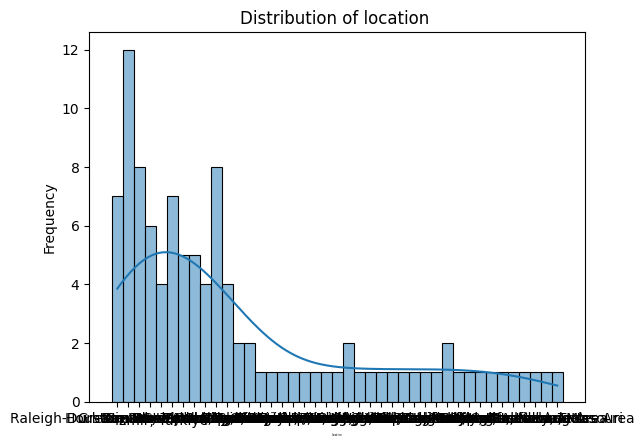

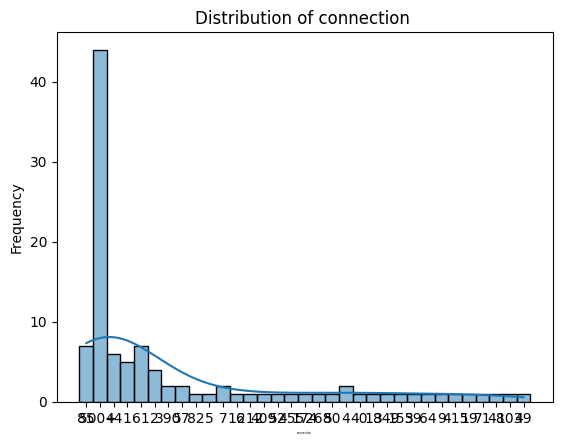

In [5]:
### plotting histograms for columsn
for cols in ['location', 'connection']:
    sns.histplot(data=df_pt, x=cols, bins=10, kde=True)
    plt.title(f'Distribution of {cols} ')
    plt.xlabel(cols, fontsize= 2)
    plt.ylabel('Frequency')
    plt.show()




In [6]:
df_pt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


In [7]:
job_title = df_pt['job_title'].apply(gensim.utils.simple_preprocess)
job_title[:5]

0    [bauer, college, of, business, graduate, magna...
1    [native, english, teacher, at, epik, english, ...
2           [aspiring, human, resources, professional]
3         [people, development, coordinator, at, ryan]
4    [advisory, board, member, at, celal, bayar, un...
Name: job_title, dtype: object

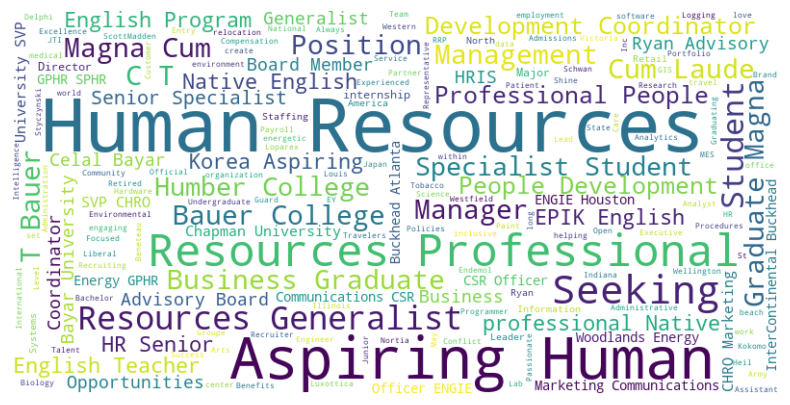

In [8]:
job_titles_list = job_title.tolist()
text = " ".join(df_pt['job_title'])
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [9]:
job_title[0]

['bauer',
 'college',
 'of',
 'business',
 'graduate',
 'magna',
 'cum',
 'laude',
 'and',
 'aspiring',
 'human',
 'resources',
 'professional']

In [10]:
print(gensim.parsing.preprocessing.STOPWORDS)

frozenset({'are', 'kg', 'might', 'already', 'three', 'and', 'just', 'de', 'same', 'two', 'its', 'made', 'noone', 'next', 'one', 'otherwise', 'give', 'between', 'something', 'un', 'once', 'thru', 'we', 'quite', 'toward', 'herself', 'though', 'must', 'therefore', 'it', 'any', 'nobody', 'hundred', 'thus', 'say', 'many', 'not', 'always', 'were', 'him', 'towards', 'an', 'enough', 'other', 'keep', 'within', 'in', 'several', 'either', 'ten', 'seems', 'with', 'about', 'formerly', 'so', 'system', 'becoming', 'amongst', 'but', 'km', 'here', 'again', 'into', 'others', 'whenever', 'didn', 'her', 'twenty', 'sometime', 'they', 'per', 'whoever', 'doesn', 'me', 'only', 'bill', 'cry', 'none', 'everywhere', 'somehow', 'rather', 'together', 'mill', 'show', 'she', 'could', 'yourself', 'my', 'somewhere', 'against', 'thence', 'ie', 'at', 'this', 'detail', 'thereupon', 'also', 'due', 'most', 'call', 'have', 'four', 'put', 'serious', 'get', 'which', 'whither', 'more', 'being', 'anyone', 'least', 'else', 'woul

In [10]:
# create a set of frequently used words
stop_words = set(gensim.parsing.preprocessing.STOPWORDS)
# stop_words = set('for a of the and to in'.split(' '))
# texts = [[word for word in doc if word not in stop_words] for doc in job_title]
texts = [[word for word in doc if word not in stop_words] for doc in job_title]
# count word frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

# only keep words that appear more than once
processed_corpus = [[token for token in text if frequency[token] > 1] for text in texts]
print(processed_corpus[:5])

[['bauer', 'college', 'business', 'graduate', 'magna', 'cum', 'laude', 'aspiring', 'human', 'resources', 'professional'], ['native', 'english', 'teacher', 'epik', 'english', 'program', 'korea'], ['aspiring', 'human', 'resources', 'professional'], ['people', 'development', 'coordinator', 'ryan'], ['advisory', 'board', 'member', 'celal', 'bayar', 'university']]


In [11]:
print(processed_corpus)

[['bauer', 'college', 'business', 'graduate', 'magna', 'cum', 'laude', 'aspiring', 'human', 'resources', 'professional'], ['native', 'english', 'teacher', 'epik', 'english', 'program', 'korea'], ['aspiring', 'human', 'resources', 'professional'], ['people', 'development', 'coordinator', 'ryan'], ['advisory', 'board', 'member', 'celal', 'bayar', 'university'], ['aspiring', 'human', 'resources', 'specialist'], ['student', 'humber', 'college', 'aspiring', 'human', 'resources', 'generalist'], ['hr', 'senior', 'specialist'], ['student', 'humber', 'college', 'aspiring', 'human', 'resources', 'generalist'], ['seeking', 'human', 'resources', 'hris', 'generalist', 'positions'], ['student', 'chapman', 'university'], ['svp', 'chro', 'marketing', 'communications', 'csr', 'officer', 'engie', 'houston', 'woodlands', 'energy', 'gphr', 'sphr'], ['human', 'resources', 'coordinator', 'buckhead', 'atlanta'], ['bauer', 'college', 'business', 'graduate', 'magna', 'cum', 'laude', 'aspiring', 'human', 'resou

In [12]:

dictionary = corpora.Dictionary(processed_corpus)
print(dictionary)
print(dictionary.token2id)

Dictionary<65 unique tokens: ['aspiring', 'bauer', 'business', 'college', 'cum']...>
{'aspiring': 0, 'bauer': 1, 'business': 2, 'college': 3, 'cum': 4, 'graduate': 5, 'human': 6, 'laude': 7, 'magna': 8, 'professional': 9, 'resources': 10, 'english': 11, 'epik': 12, 'korea': 13, 'native': 14, 'program': 15, 'teacher': 16, 'coordinator': 17, 'development': 18, 'people': 19, 'ryan': 20, 'advisory': 21, 'bayar': 22, 'board': 23, 'celal': 24, 'member': 25, 'university': 26, 'specialist': 27, 'generalist': 28, 'humber': 29, 'student': 30, 'hr': 31, 'senior': 32, 'hris': 33, 'positions': 34, 'seeking': 35, 'chapman': 36, 'chro': 37, 'communications': 38, 'csr': 39, 'energy': 40, 'engie': 41, 'gphr': 42, 'houston': 43, 'marketing': 44, 'officer': 45, 'sphr': 46, 'svp': 47, 'woodlands': 48, 'atlanta': 49, 'buckhead': 50, 'internship': 51, 'management': 52, 'opportunities': 53, 'manager': 54, 'retail': 55, 'staffing': 56, 'america': 57, 'director': 58, 'north': 59, 'position': 60, 'major': 61, '

In [13]:
print(len(dictionary))

65


In [14]:
bow_corpus =[dictionary.doc2bow(text) for text in processed_corpus]
print(bow_corpus[:5])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1)], [(11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)], [(0, 1), (6, 1), (9, 1), (10, 1)], [(17, 1), (18, 1), (19, 1), (20, 1)], [(21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)]]


In [15]:
# train the model
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
for doc in corpus_tfidf:
    print(doc)

[(0, 0.15409025871479304), (1, 0.38181197519664134), (2, 0.31785994113068355), (3, 0.28373757014367385), (4, 0.38181197519664134), (5, 0.38181197519664134), (6, 0.07548810304306029), (7, 0.38181197519664134), (8, 0.38181197519664134), (9, 0.2332711123621775), (10, 0.07548810304306029)]
[(11, 0.6666666666666667), (12, 0.33333333333333337), (13, 0.33333333333333337), (14, 0.33333333333333337), (15, 0.33333333333333337), (16, 0.33333333333333337)]
[(0, 0.514905501818844), (6, 0.252249817106758), (9, 0.7794949542722511), (10, 0.252249817106758)]
[(17, 0.4282922112779002), (18, 0.5217169672528987), (19, 0.5217169672528987), (20, 0.5217169672528987)]
[(21, 0.42877361248588103), (22, 0.42877361248588103), (23, 0.42877361248588103), (24, 0.42877361248588103), (25, 0.42877361248588103), (26, 0.28419350129627785)]
[(0, 0.4298555394513991), (6, 0.2105842350216153), (10, 0.2105842350216153), (27, 0.8523689196138423)]
[(0, 0.24004117745157263), (3, 0.4420052311716772), (6, 0.1175950594747249), (10,

In [16]:
index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=len(dictionary))

In [17]:
query_doc = "Native English Teacher at EPIK (English Program in Korea)".lower()
query_bow = dictionary.doc2bow(gensim.utils.simple_preprocess(query_doc))
similarity = index[tfidf[query_bow]]
print(similarity)

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [18]:
## top 10 similar documents
top_10 = sorted(enumerate(similarity), key=lambda item: -item[1])[:10]
print("Top 10 similar documents (index, similarity score):")
for doc_position, doc_score in top_10:
    print(f"Document {doc_position}: Similarity Score {doc_score}")

Top 10 similar documents (index, similarity score):
Document 1: Similarity Score 1.0
Document 15: Similarity Score 1.0
Document 19: Similarity Score 1.0
Document 31: Similarity Score 1.0
Document 44: Similarity Score 1.0
Document 0: Similarity Score 0.0
Document 2: Similarity Score 0.0
Document 3: Similarity Score 0.0
Document 4: Similarity Score 0.0
Document 5: Similarity Score 0.0


In [19]:
## top 10 similar documents
top_10 = sorted(enumerate(similarity), key=lambda item: -item[1])[:10]
print(top_10)

[(1, 1.0), (15, 1.0), (19, 1.0), (31, 1.0), (44, 1.0), (0, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0)]


In [20]:
for i, sim in sorted(enumerate(similarity), key=lambda item: -item[1], reverse=False):
    print(f"Document {i}: Similarity {sim}")

Document 1: Similarity 1.0
Document 15: Similarity 1.0
Document 19: Similarity 1.0
Document 31: Similarity 1.0
Document 44: Similarity 1.0
Document 0: Similarity 0.0
Document 2: Similarity 0.0
Document 3: Similarity 0.0
Document 4: Similarity 0.0
Document 5: Similarity 0.0
Document 6: Similarity 0.0
Document 7: Similarity 0.0
Document 8: Similarity 0.0
Document 9: Similarity 0.0
Document 10: Similarity 0.0
Document 11: Similarity 0.0
Document 12: Similarity 0.0
Document 13: Similarity 0.0
Document 14: Similarity 0.0
Document 16: Similarity 0.0
Document 17: Similarity 0.0
Document 18: Similarity 0.0
Document 20: Similarity 0.0
Document 21: Similarity 0.0
Document 22: Similarity 0.0
Document 23: Similarity 0.0
Document 24: Similarity 0.0
Document 25: Similarity 0.0
Document 26: Similarity 0.0
Document 27: Similarity 0.0
Document 28: Similarity 0.0
Document 29: Similarity 0.0
Document 30: Similarity 0.0
Document 32: Similarity 0.0
Document 33: Similarity 0.0
Document 34: Similarity 0.0
Do

In [21]:
for doc, as_text in zip(df_pt['job_title'], top_10):
    print(f"Document: {doc} \nSimilarity Score: {as_text}\n")

Document: 2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional 
Similarity Score: (1, 1.0)

Document: Native English Teacher at EPIK (English Program in Korea) 
Similarity Score: (15, 1.0)

Document: Aspiring Human Resources Professional 
Similarity Score: (19, 1.0)

Document: People Development Coordinator at Ryan 
Similarity Score: (31, 1.0)

Document: Advisory Board Member at Celal Bayar University 
Similarity Score: (44, 1.0)

Document: Aspiring Human Resources Specialist 
Similarity Score: (0, 0.0)

Document: Student at Humber College and Aspiring Human Resources Generalist 
Similarity Score: (2, 0.0)

Document: HR Senior Specialist 
Similarity Score: (3, 0.0)

Document: Student at Humber College and Aspiring Human Resources Generalist 
Similarity Score: (4, 0.0)

Document: Seeking Human Resources HRIS and Generalist Positions 
Similarity Score: (5, 0.0)



In [46]:
import tensorflow_hub as hub
import tensorflow_text as text

In [47]:
import tensorflow as tf
import gc

# Clear any existing Keras/TensorFlow state to avoid duplicate metric names
try:
    tf.keras.backend.clear_session()
except Exception:
    pass
_ = gc.collect()

In [48]:
# Create TF Hub layers with explicit unique names and guard re-creation
if 'preprocessor' not in globals():
    preprocessor = hub.KerasLayer(
        "https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3",
        name="tfhub_bert_preprocess"
    )
if 'encoder' not in globals():
    encoder = hub.KerasLayer(
        "https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/bert-en-uncased-l-10-h-128-a-2/2",
        trainable=True,
        name="tfhub_bert_encoder"
    )

In [49]:
encoder_inputs = preprocessor(df_pt['job_title'].tolist())
outputs = encoder(encoder_inputs)
#pooled_output = outputs["pooled_output"]      # [batch_size, 128].
#sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 128].

In [50]:
pooled_output=outputs["pooled_output"]

In [51]:
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 128].

In [52]:
embeddings = pooled_output.numpy()
print(embeddings.shape)  # (num_documents, 128)


(104, 128)


In [53]:
print(len(embeddings[0]))

128


In [54]:
print(outputs)

{'sequence_output': <tf.Tensor: shape=(104, 128, 128), dtype=float32, numpy=
array([[[ 0.00439079,  0.21662268,  1.5593908 , ...,  0.7527493 ,
          0.60505164, -1.22944   ],
        [ 0.18407603, -0.36442775,  2.1236506 , ...,  0.47195464,
          1.0677015 , -0.7166042 ],
        [-0.88481885, -1.3945022 ,  1.2813371 , ...,  1.1272306 ,
          1.1326616 ,  0.24166231],
        ...,
        [ 0.29881293,  0.7883085 ,  0.47175768, ...,  0.15689132,
          0.6369212 , -1.1877062 ],
        [ 0.80040735, -0.837512  ,  1.1820649 , ..., -0.42413968,
          1.0853454 , -0.8043834 ],
        [ 0.9467961 , -0.23741448,  1.5282518 , ..., -0.8291459 ,
          0.64456666, -1.1766754 ]],

       [[ 0.6929683 ,  0.514472  ,  0.69285214, ...,  1.4656947 ,
          1.0900869 , -0.20731671],
        [ 0.23879974, -1.4145161 , -0.7577404 , ...,  1.8066388 ,
          1.6590459 , -1.039355  ],
        [ 0.2674871 , -0.43256283, -0.58934164, ..., -0.09961306,
          0.26779258, -0.3

In [40]:
## similarity with BERT embeddings
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

similarity_matrix = cosine_similarity(embeddings)

print(similarity_matrix)
print(cosine_distances(embeddings))

[[1.0000001  0.8272313  0.90825623 ... 0.8627961  0.6623215  0.8837833 ]
 [0.8272313  0.99999994 0.8770547  ... 0.87645555 0.7736362  0.86416346]
 [0.90825623 0.8770547  0.9999997  ... 0.9506318  0.82344854 0.94361216]
 ...
 [0.8627961  0.87645555 0.9506318  ... 0.9999997  0.8112357  0.979981  ]
 [0.6623215  0.7736362  0.82344854 ... 0.8112357  0.9999998  0.7747129 ]
 [0.8837833  0.86416346 0.94361216 ... 0.979981   0.7747129  1.0000002 ]]
[[0.         0.17276871 0.09174377 ... 0.13720387 0.3376785  0.11621672]
 [0.17276871 0.         0.12294531 ... 0.12354445 0.22636378 0.13583654]
 [0.09174377 0.12294531 0.         ... 0.0493682  0.17655146 0.05638784]
 ...
 [0.13720387 0.12354445 0.0493682  ... 0.         0.18876427 0.02001899]
 [0.3376785  0.22636378 0.17655146 ... 0.18876427 0.         0.22528708]
 [0.11621672 0.13583654 0.05638784 ... 0.02001899 0.22528708 0.        ]]


In [ ]:
from sentence_transformers import SentenceTransformer, util

model_tf = SentenceTransformer("all-mpnet-base-v2")

query = "Native English Teacher at EPIK (English Program in Korea)"
docs = df_pt['job_title'].tolist()
embeddings = model_tf.encode(docs, convert_to_tensor=True)
query_embedding = model_tf.encode(query, convert_to_tensor=True)

scores = util.cos_sim(query_embedding, embeddings)
print(scores)


tensor([[0.2652, 1.0000, 0.2645, 0.2719, 0.3687, 0.2960, 0.3535, 0.2803, 0.3535,
         0.2314, 0.2772, 0.1943, 0.3164, 0.2652, 0.2652, 1.0000, 0.2645, 0.2719,
         0.2652, 1.0000, 0.2645, 0.2719, 0.3687, 0.2960, 0.3535, 0.2803, 0.2482,
         0.2347, 0.2482, 0.2347, 0.2652, 1.0000, 0.2645, 0.2719, 0.3687, 0.2960,
         0.3535, 0.2803, 0.3535, 0.2314, 0.2772, 0.1943, 0.3164, 0.2652, 1.0000,
         0.2645, 0.2719, 0.3687, 0.2960, 0.3535, 0.2803, 0.3535, 0.2314, 0.2772,
         0.1943, 0.3164, 0.2652, 0.2645, 0.2719, 0.2960, 0.2803, 0.2314, 0.2772,
         0.1943, 0.3164, 0.2761, 0.2799, 0.3041, 0.2386, 0.2504, 0.2598, 0.1941,
         0.2982, 0.3293, 0.1659, 0.2853, 0.1707, 0.3205, 0.3274, 0.2275, 0.2265,
         0.2546, 0.2957, 0.1922, 0.2012, 0.2443, 0.1124, 0.2610, 0.2934, 0.3138,
         0.2985, 0.1800, 0.2379, 0.3381, 0.2812, 0.2655, 0.2645, 0.2801, 0.2842,
         0.3038, 0.3602, 0.0672, 0.0339, 0.2132]])


In [5]:
print(docs)

['2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional', 'Native English Teacher at EPIK (English Program in Korea)', 'Aspiring Human Resources Professional', 'People Development Coordinator at Ryan', 'Advisory Board Member at Celal Bayar University', 'Aspiring Human Resources Specialist', 'Student at Humber College and Aspiring Human Resources Generalist', 'HR Senior Specialist', 'Student at Humber College and Aspiring Human Resources Generalist', 'Seeking Human Resources HRIS and Generalist Positions', 'Student at Chapman University', 'SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR', 'Human Resources Coordinator at InterContinental Buckhead Atlanta', '2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional', '2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional', 'Native En

In [6]:
import faiss
import pickle
from sentence_transformers import SentenceTransformer

Build an index (store vector & metadata)

In [38]:
MODEL_NAME = "intfloat/e5-base-v2"   # great for retrieval; or "all-mpnet-base-v2"
INDEX_PATH = "jd.index"
META_PATH  = "jd_meta.pkl"

model = SentenceTransformer(MODEL_NAME)
docs = ["passage: " + t for t in df_pt["job_title"].tolist()]

emb = model.encode(docs, batch_size=64, show_progress_bar=True, normalize_embeddings=True)
emb = emb.astype("float32")

d = emb.shape[1]  # vector dimension

# Cosine similarity = inner product when vectors are normalized
index = faiss.IndexFlatIP(d)
index.add(emb)

# Save
faiss.write_index(index, INDEX_PATH)
with open(META_PATH, "wb") as f:
    pickle.dump(df_pt.to_dict(orient="records"), f)

print(f"Indexed {index.ntotal} job descriptions. dim={d}")

Batches: 100%|██████████| 2/2 [00:05<00:00,  2.95s/it]

Indexed 104 job descriptions. dim=768


Search (semantic matching)

In [39]:
def load_jd_search(
    model_name: str = "intfloat/e5-base-v2",
    index_path: str = "jd.index",
    meta_path: str = "jd_meta.pkl",
    score_threshold: float = 0.6,
):
    model = SentenceTransformer(model_name)
    index = faiss.read_index(index_path)

    with open(meta_path, "rb") as f:
        meta = pickle.load(f)

    def search_jds(query: str, top_k: int = 5):
        q = "query: " + query  # E5 best practice
        qv = model.encode([q], normalize_embeddings=True).astype(np.float32)

        scores, idxs = index.search(qv, top_k)

        results = []
        for score, i in zip(scores[0], idxs[0]):
            if i == -1:
                continue
            if score < score_threshold:
                continue
            row = meta[i]
            results.append({
                "score": round(float(score),4),
                "id": row.get("id"),
                "job_title": row.get("job_title"),
                "location": row.get("location"),
            })

        return results

    return search_jds

In [40]:
print(f'Enter the job title to search for relevant potential talents:', job_title_input := input())

Enter the job title to search for relevant potential talents: Business Management Major and Aspiring Human Resources Manager


In [41]:
print (job_title_input)

Business Management Major and Aspiring Human Resources Manager


In [42]:
search_jds = load_jd_search(score_threshold=0.6)

# results = search_jds("Aspiring Human Resources Professional", 
#                      top_k=10)
results = search_jds(job_title_input, 
                     top_k=10)
for r in results:
    print(r)

{'score': 0.9615, 'id': 72, 'job_title': 'Business Management Major and Aspiring Human Resources Manager', 'location': 'Monroe, Louisiana Area'}
{'score': 0.9214, 'id': 88, 'job_title': 'Human Resources Management Major', 'location': 'Milpitas, California'}
{'score': 0.9012, 'id': 97, 'job_title': 'Aspiring Human Resources Professional', 'location': 'Kokomo, Indiana Area'}
{'score': 0.9012, 'id': 58, 'job_title': 'Aspiring Human Resources Professional', 'location': 'Raleigh-Durham, North Carolina Area'}
{'score': 0.9012, 'id': 46, 'job_title': 'Aspiring Human Resources Professional', 'location': 'Raleigh-Durham, North Carolina Area'}
{'score': 0.9012, 'id': 33, 'job_title': 'Aspiring Human Resources Professional', 'location': 'Raleigh-Durham, North Carolina Area'}
{'score': 0.9012, 'id': 21, 'job_title': 'Aspiring Human Resources Professional', 'location': 'Raleigh-Durham, North Carolina Area'}
{'score': 0.9012, 'id': 17, 'job_title': 'Aspiring Human Resources Professional', 'location'

In [ ]:
## pretty print results
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results)



[   {   'id': 72,
        'job_title': 'Business Management Major and Aspiring Human Resources '
                     'Manager',
        'location': 'Monroe, Louisiana Area',
        'score': 0.9615},
    {   'id': 88,
        'job_title': 'Human Resources Management Major',
        'location': 'Milpitas, California',
        'score': 0.9214},
    {   'id': 97,
        'job_title': 'Aspiring Human Resources Professional',
        'location': 'Kokomo, Indiana Area',
        'score': 0.9012},
    {   'id': 58,
        'job_title': 'Aspiring Human Resources Professional',
        'location': 'Raleigh-Durham, North Carolina Area',
        'score': 0.9012},
    {   'id': 46,
        'job_title': 'Aspiring Human Resources Professional',
        'location': 'Raleigh-Durham, North Carolina Area',
        'score': 0.9012},
    {   'id': 33,
        'job_title': 'Aspiring Human Resources Professional',
        'location': 'Raleigh-Durham, North Carolina Area',
        'score': 0.9012},
    {   '

In [47]:
## save from json to dataframe
import pandas as pd
df_results = pd.DataFrame(results, columns=["score", "id", "job_title", "location"])
df_results

,score,id,job_title,location
0,0.9615,72,Business Management Major and Aspiring Human R...,"Monroe, Louisiana Area"
1,0.9214,88,Human Resources Management Major,"Milpitas, California"
2,0.9012,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area"
3,0.9012,58,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area"
4,0.9012,46,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area"
5,0.9012,33,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area"
6,0.9012,21,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area"
7,0.9012,17,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area"
8,0.9012,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area"
9,0.8968,73,"Aspiring Human Resources Manager, seeking inte...","Houston, Texas Area"
